In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from pylab import rcParams
rcParams['figure.figsize'] = (9, 5)

import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import datetime
from dateutil.relativedelta import relativedelta
from arch import arch_model

# отключим предупреждения Anaconda
import warnings
warnings.simplefilter('ignore')

p = print

Используем полезные функции, любезно предоставленные лектором

In [2]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    rolmean = pd.rolling_mean(y, window=12)
    rolstd = pd.rolling_std(y, window=12)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        rolmean.plot(ax=ts_ax, color='red')
        rolstd.plot(ax=ts_ax, color='black')
        ts_ax.set_title('Original(blue), Rolling Mean(red) & Standard Deviation(black)')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')

        plt.tight_layout()
    return

In [3]:
#######################
# разложение на компоненты
#########################
def seasonal_decompose_plot(y,  freq=None):
    if not isinstance(y, pd.Series): # не является рядом?
        y = pd.Series(y) # преобразовать в ряд

    decomposition = seasonal_decompose(Y, freq=freq)
    # fig = plt.figure()
    fig = decomposition.plot()
    fig.set_size_inches(15, 8)
    return

In [4]:
################
 # Dickey-Fuller
##################
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [5]:
# Выбор модели ARIMA согласно AIC
def arima_best_order(timeseries):
    max_lag = 30
    best_aic = np.inf
    best_order = None
    best_mdl = None
    pq_rng = range(5)  # [0,1,2,3,4]
    d_rng = range(2)  # [0,1]
    for i in pq_rng:
        for d in d_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = smt.ARIMA(timeseries, order=(i, d, j)).fit(maxlag=max_lag, method='mle', trend='nc')
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    p('aic: {:6.5f} | order: {}'.format(best_aic, best_order))
    return best_mdl

In [6]:
# зафиксируем выборку
np.random.seed(1)

In [136]:
# Выбор модели ARIMA согласно AIC
def arima_best_order(timeseries):
    max_lag = 30
    best_aic = np.inf
    best_order = None
    best_mdl = None
    pq_rng = range(5)  # [0,1,2,3,4]
    d_rng = range(3)  # [0,1]
    for i in pq_rng:
        for d in d_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = smt.ARIMA(timeseries, order=(i, d, j)).fit(maxlag=max_lag, method='mle', trend='nc')
                    tmp_aic = tmp_mdl.
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    p('aic: {:6.5f} | order: {}'.format(best_aic, best_order))
    return best_mdl

# Исследуем реальные данные

In [82]:
# Загрузим данные
cols = ['num_tr']
df = pd.read_csv('Sales.csv', index_col=0, names=cols , skiprows=1)
df.index.name='date'
df.reset_index(inplace=True)

In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
date      144 non-null object
num_tr    144 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.3+ KB


In [84]:
df.describe()

,num_tr
count,144.000000
mean,389.694444
std,171.500016
min,138.000000
25%,248.500000
50%,369.000000
75%,509.250000
max,871.000000


In [85]:
df.tail()

,date,num_tr
139,Aug-14,848
140,Sep-14,640
141,Oct-14,581
142,Nov-14,519
143,Dec-14,605


In [86]:
#  Укажем формат времени
start = datetime.datetime.strptime("2003-01-01", "%Y-%m-%d")
date_list = [start + relativedelta(months=x) for x in range(0,144)]
df['index'] = date_list
df.set_index(['index'], inplace=True)
df.index.name=None

п. 2 Постройте график ряда, сделайте предположение о тренде, сезонности, стационарности

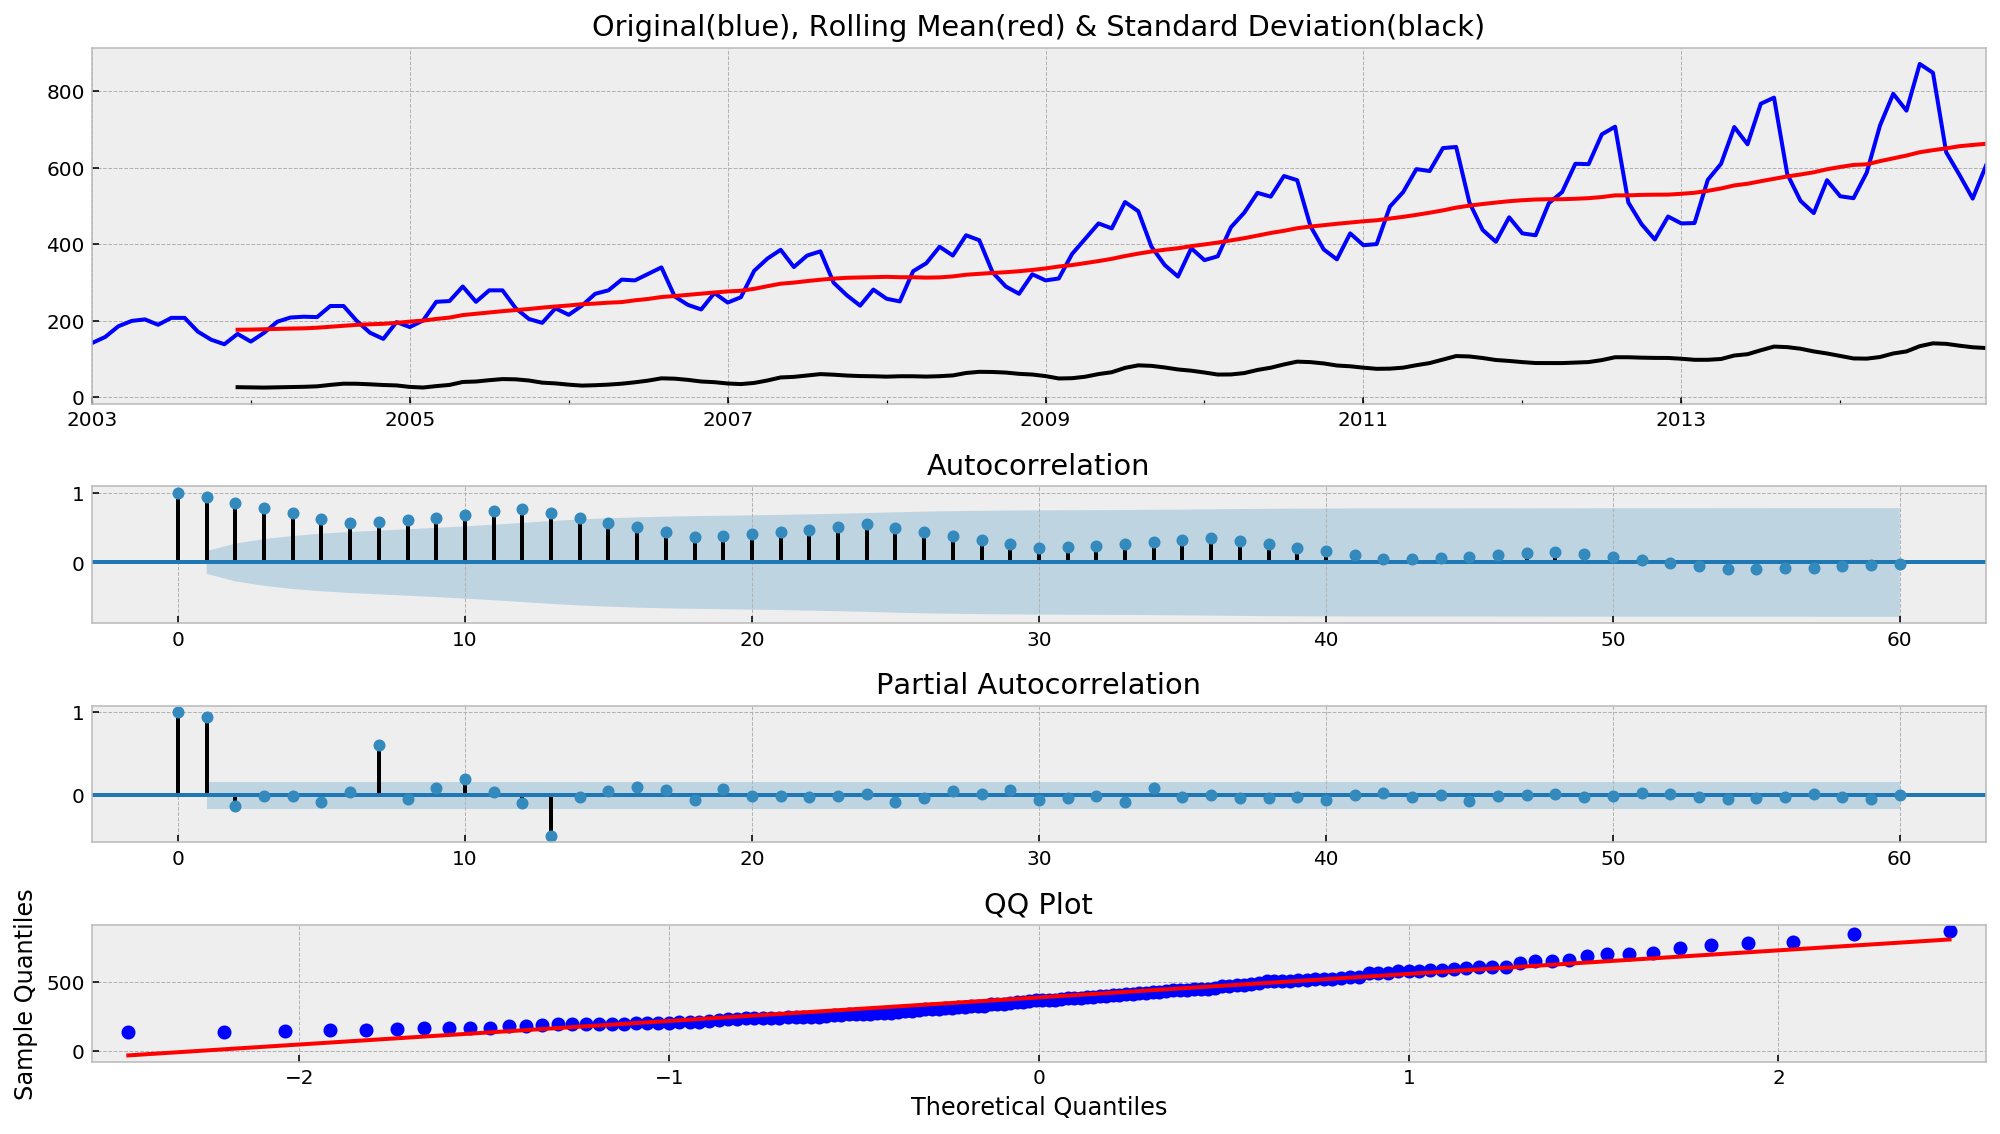

In [137]:
tsplot(df.num_tr, lags=60)

Из анализа изображений: временной ряд с трендом, 
нестационарный - график автокорреляционной функции медленно угасает;
частная автокорреляция показывает, что есть сезонность в 6-ом и 12-ом месяцах;
QQ график показывает, что временной ряд далек от стационарности.

In [89]:
test_stationarity(df.num_tr)

Results of Dickey-Fuller Test:
Test Statistic                   1.108825
p-value                          0.995291
#Lags Used                      14.000000
Number of Observations Used    129.000000
Critical Value (1%)             -3.482088
Critical Value (5%)             -2.884219
Critical Value (10%)            -2.578864
dtype: float64


Гипотеза о стационарности после теста Дики-Фуллера отвергается, нестационарный временной ряд.

п. 3 Разделите контрольную (последние 5 мес.) и обучающую (остальное) выборки

In [95]:
train = df[df.index < '2014-08-01']
test = df[df.index >= '2014-08-01']

In [97]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5 entries, 2014-08-01 to 2014-12-01
Data columns (total 2 columns):
date      5 non-null object
num_tr    5 non-null int64
dtypes: int64(1), object(1)
memory usage: 120.0+ bytes


In [98]:
test.head()

,date,num_tr
2014-08-01,Aug-14,848
2014-09-01,Sep-14,640
2014-10-01,Oct-14,581
2014-11-01,Nov-14,519
2014-12-01,Dec-14,605


п. 4 Приведите исходный ряд к стационарному

Results of Dickey-Fuller Test:
Test Statistic                  -1.732472
p-value                          0.414464
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


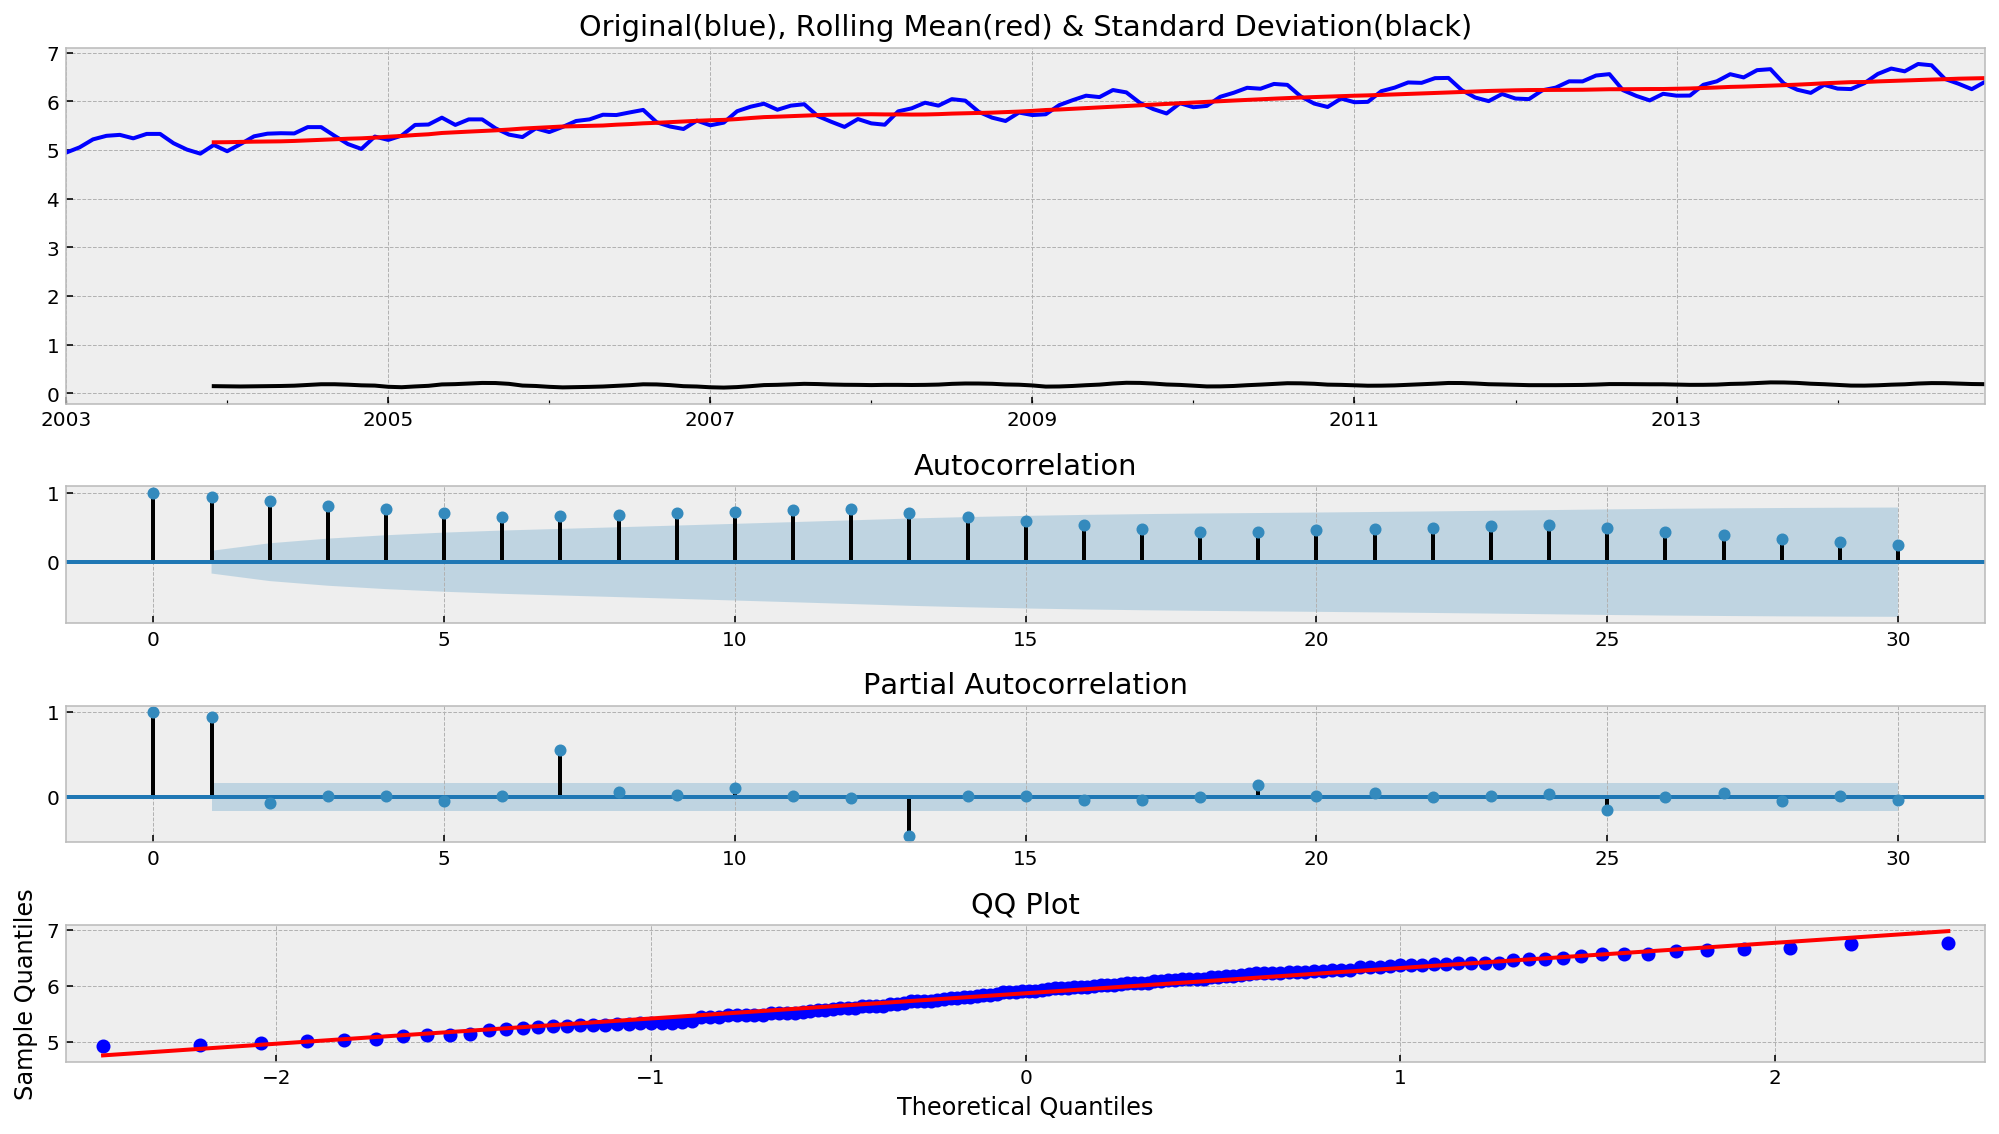

In [138]:
# логарифмируем, на всякий случаем проверяем ДФ, отрисовываем графики, чтобы понять, как изменился временной ряд
df.num_tr_log = df.num_tr.apply(lambda x: np.log(x))
test_stationarity(df.num_tr_log.dropna(inplace=False))
tsplot(df.num_tr_log, lags=30)

Нестационарный, продолжаем работу с данными



Results of Dickey-Fuller Test:
Test Statistic                  -2.543481
p-value                          0.105250
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


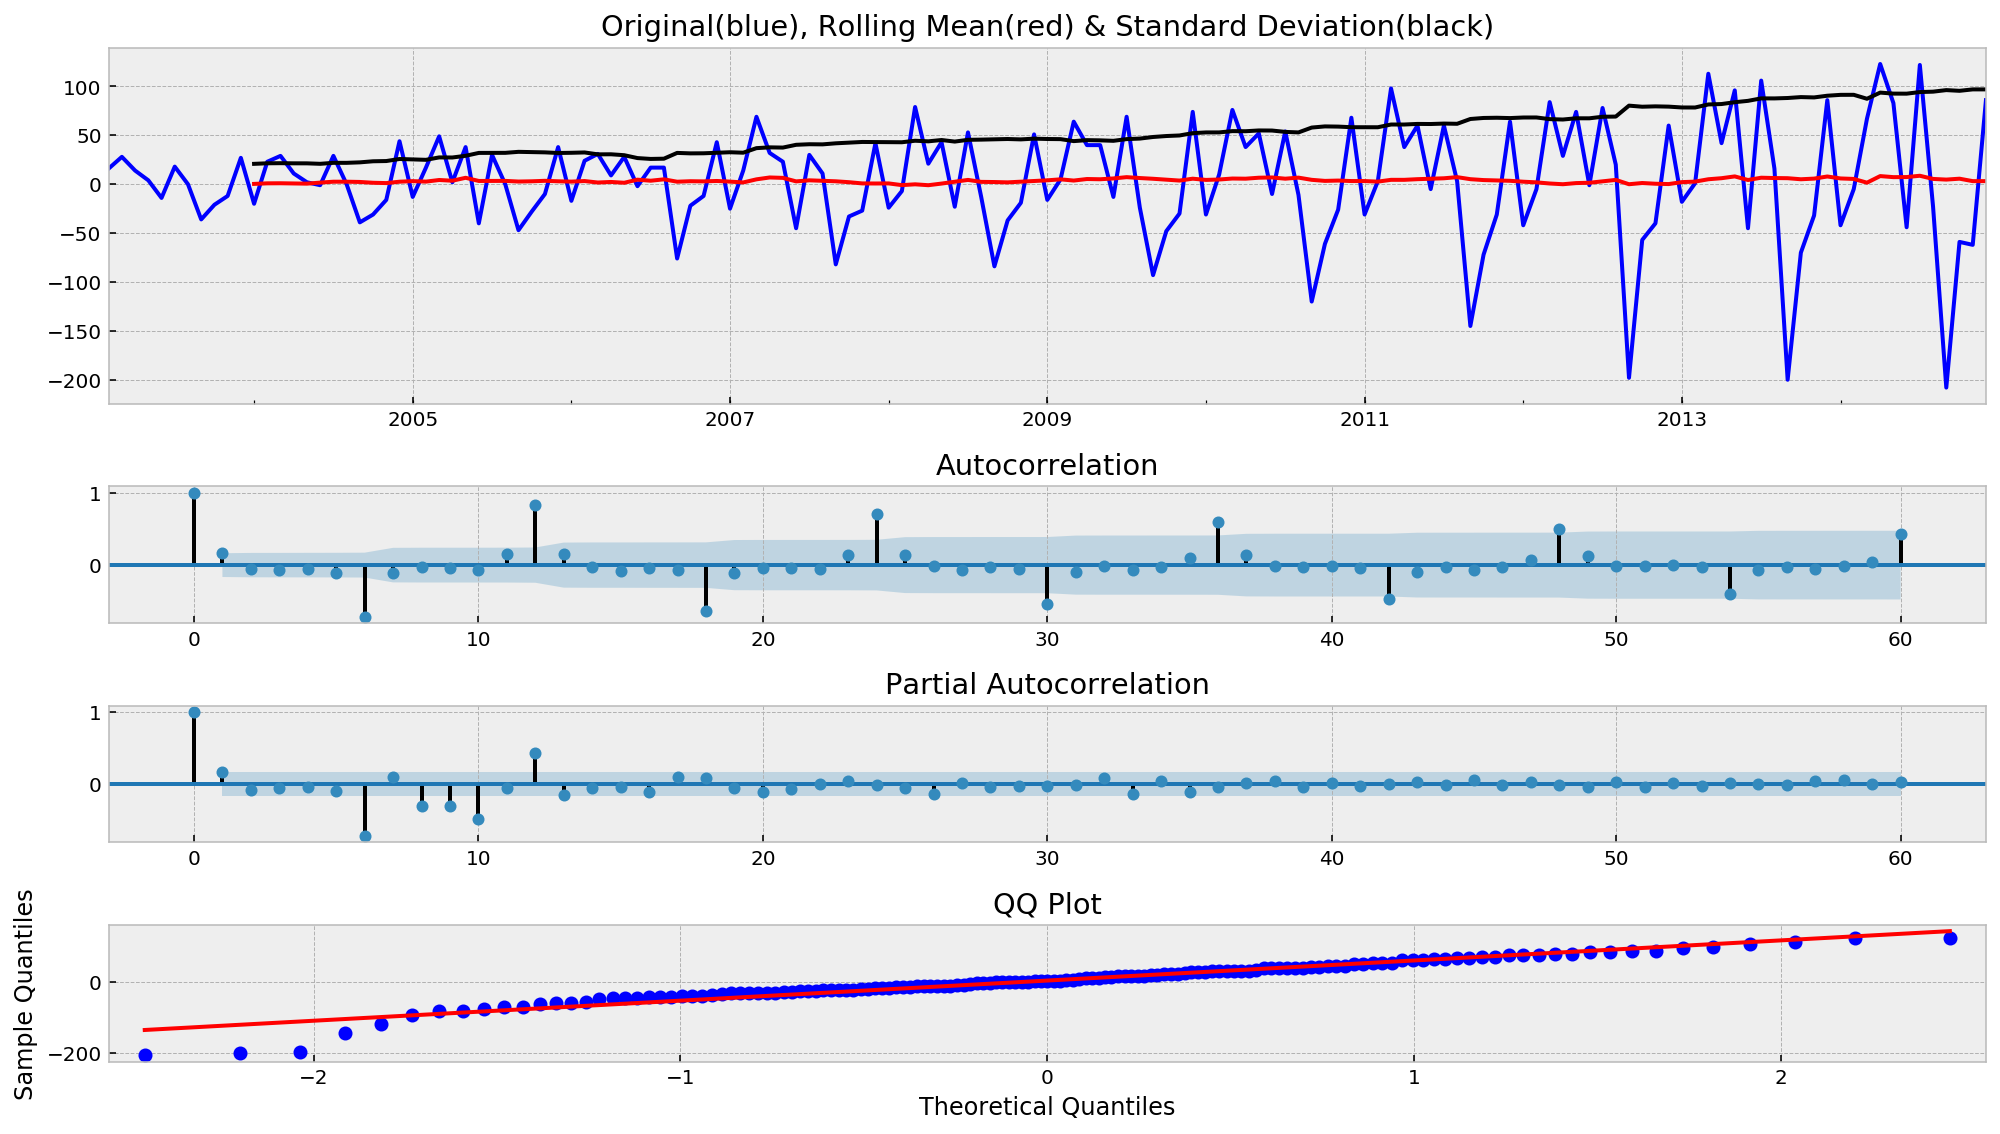

In [139]:
#первые разности 
df['first_difference'] = df.num_tr - df.num_tr.shift(1)
test_stationarity(df.first_difference.dropna(inplace=False))
tsplot(df.first_difference[1:], lags = 60)

Нестационарный, продолжаем работать с данными

Results of Dickey-Fuller Test:
Test Statistic                  -2.680467
p-value                          0.077480
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


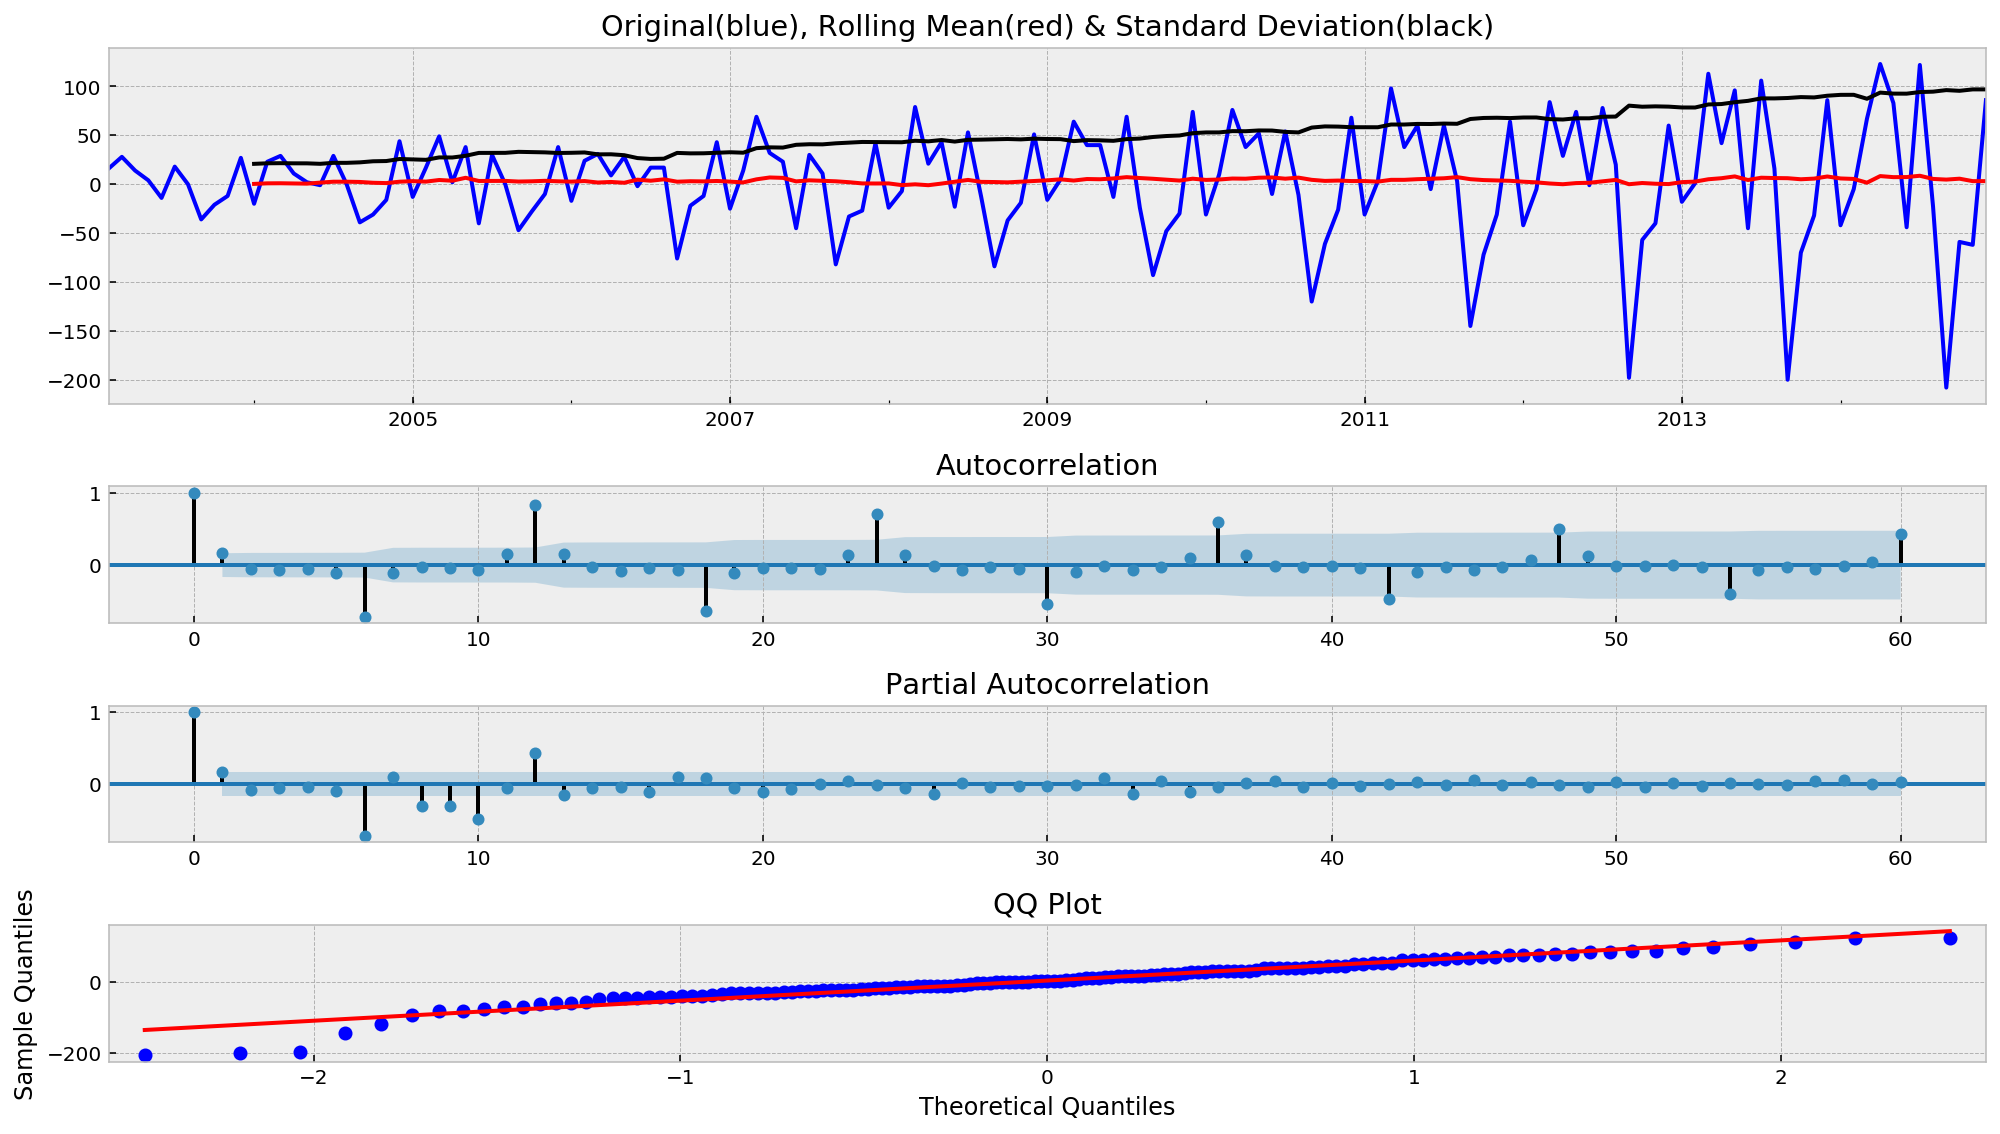

In [140]:
# логарифм первых разностей 
df['log_first_difference'] = df.num_tr_log - df.num_tr_log.shift(1)
test_stationarity(df.log_first_difference.dropna(inplace=False))
tsplot(df.first_difference[1:], lags = 60)

Нестационарный, продолжаем преобразовывать временной ряд

Results of Dickey-Fuller Test:
Test Statistic                  -3.504615
p-value                          0.007869
#Lags Used                       1.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


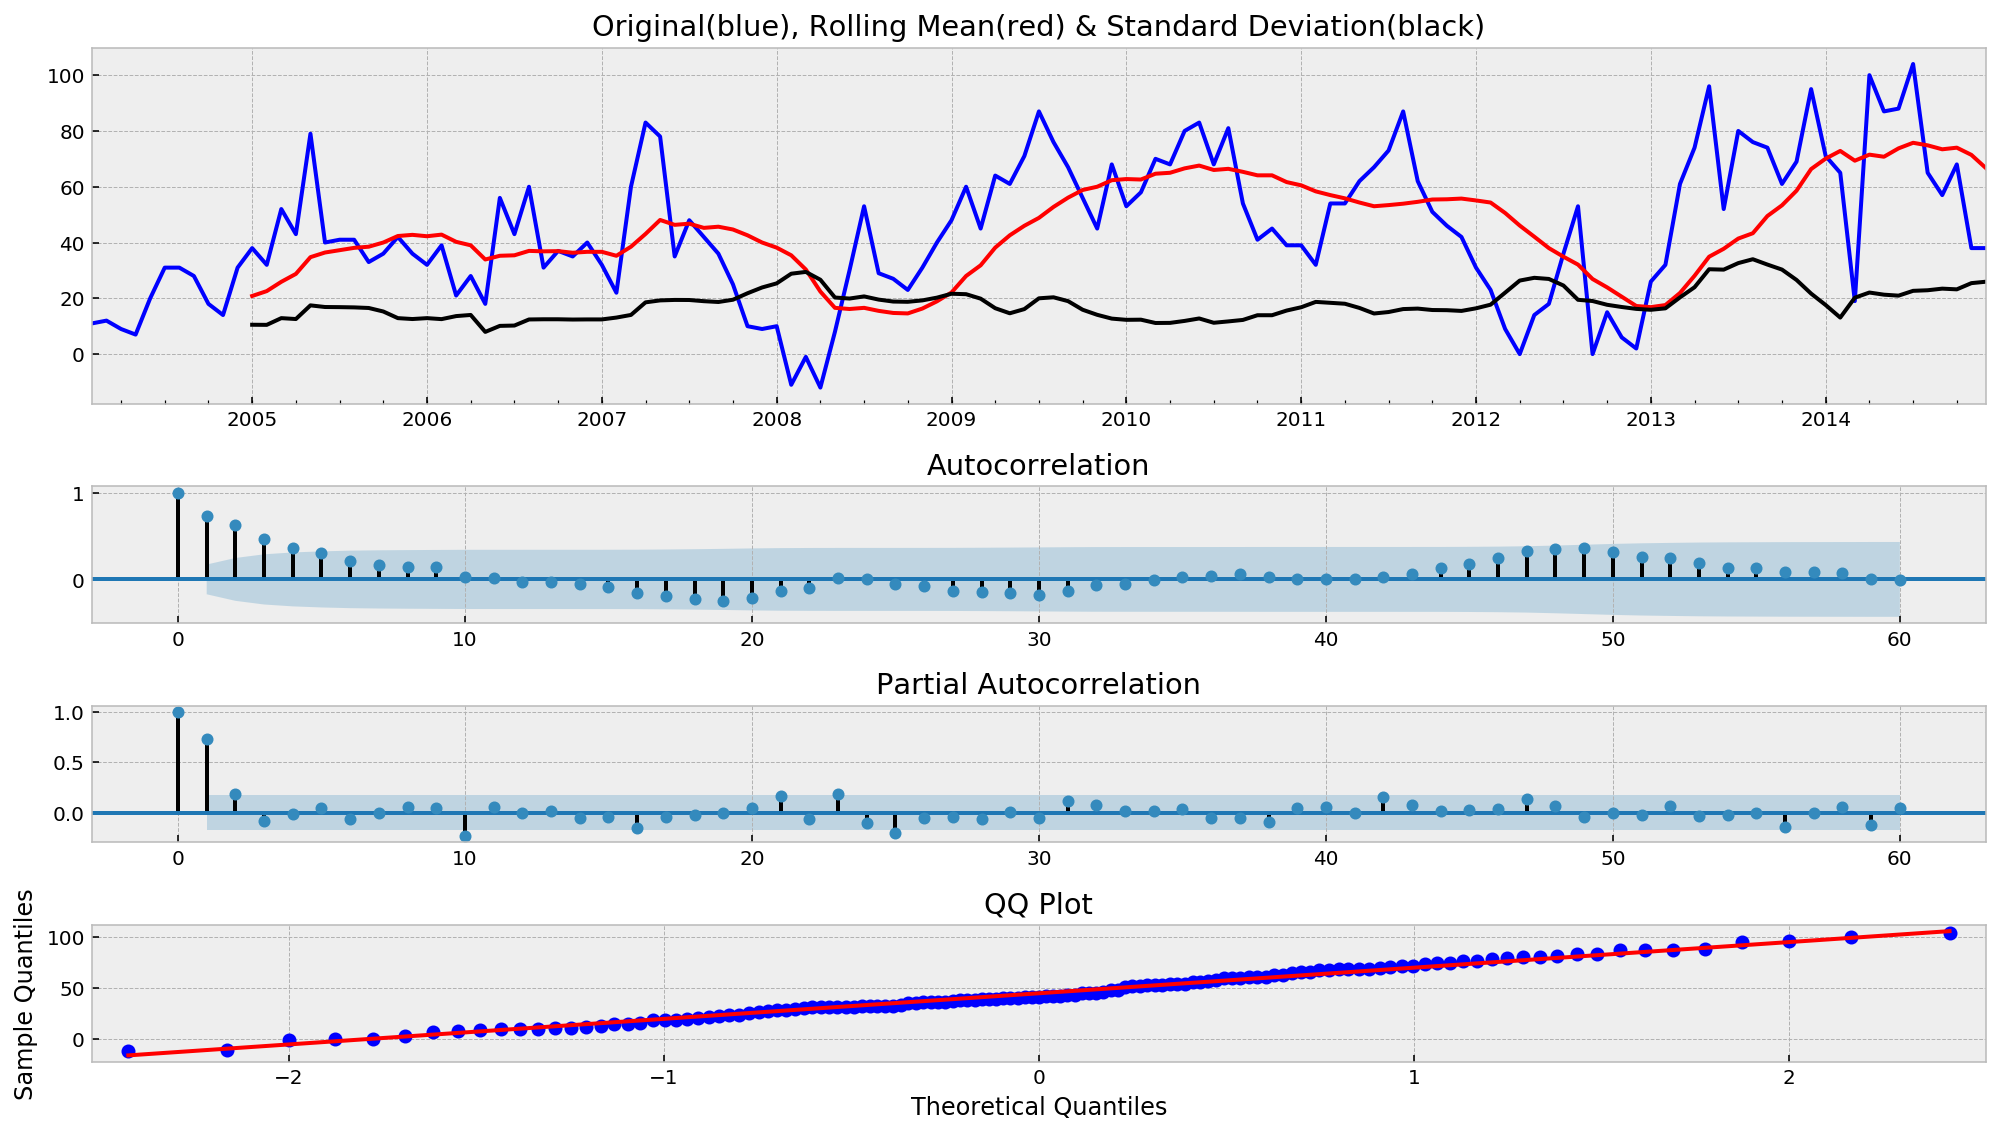

In [141]:
# seasonal component 12 month, ярко выражена на графике частой автокорреляции, 
# есть компоента на 6-ти месяцах, ее пока не принимаем во внимание
df['seasonal_difference'] = df.num_tr -  df.num_tr.shift(12)
test_stationarity(df.seasonal_difference.dropna(inplace=False))
tsplot(df.seasonal_difference[13:], lags = 60)

По тесту ДФ ряд можно считать стационарным (p-value < 0.05), по посмотрим, можно ли как-то улучшить результат, улучшить поведение
автокорреляционной фукции и частной автокорреляции.

Results of Dickey-Fuller Test:
Test Statistic                  -2.716590
p-value                          0.071211
#Lags Used                      12.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


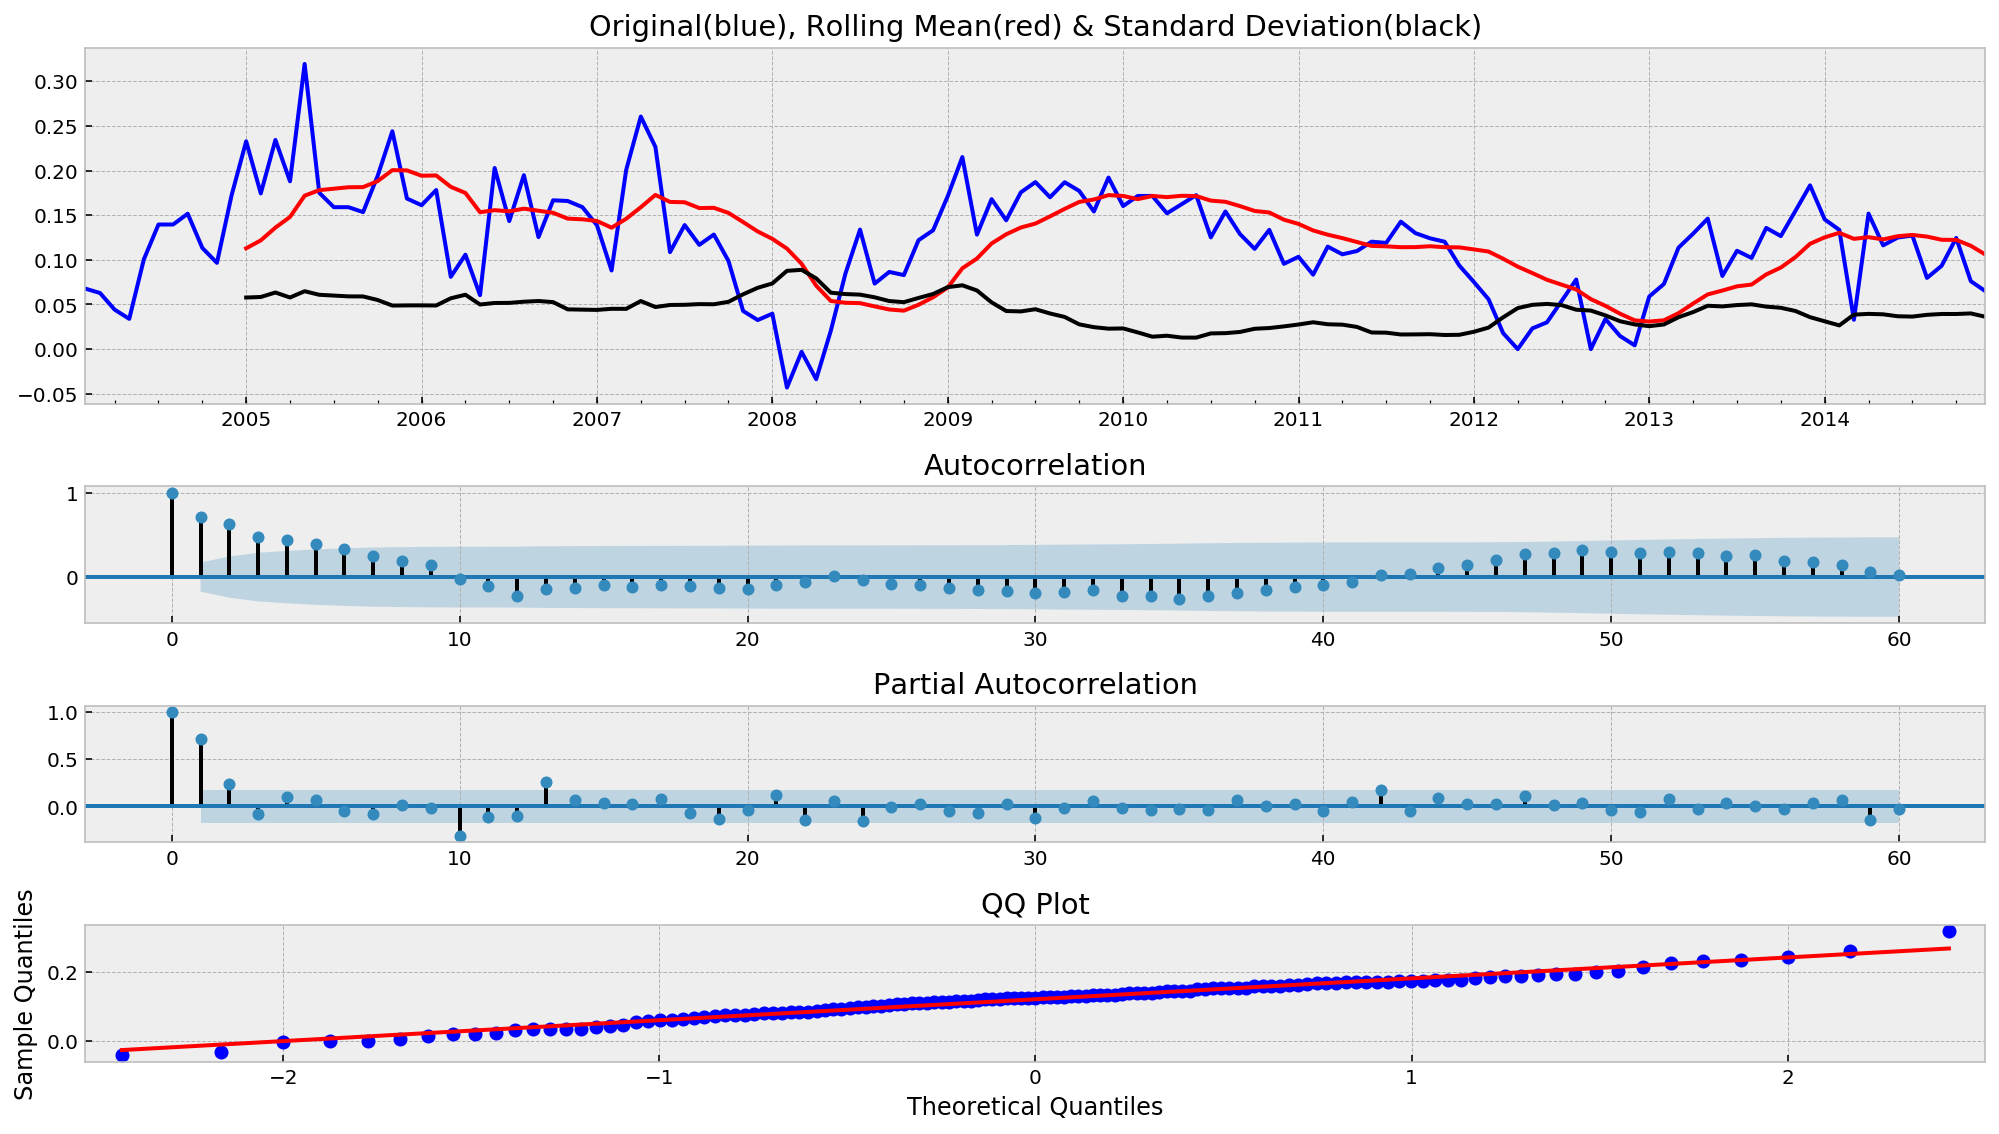

In [142]:
# log seasonal component 12 month 
df['log_seasonal_difference'] = df.num_tr_log - df.num_tr_log.shift(12)
test_stationarity(df.log_seasonal_difference.dropna(inplace=False))
tsplot(df.log_seasonal_difference[13:], lags = 60)

Удаление сезонной компоненты из логарифмированного ряда не дает лучший результат, 
чем простое удаление сезонной компоненты. Продолжаем эксперименты далее.

Results of Dickey-Fuller Test:
Test Statistic                -1.542214e+01
p-value                        3.024764e-28
#Lags Used                     0.000000e+00
Number of Observations Used    1.300000e+02
Critical Value (1%)           -3.481682e+00
Critical Value (5%)           -2.884042e+00
Critical Value (10%)          -2.578770e+00
dtype: float64


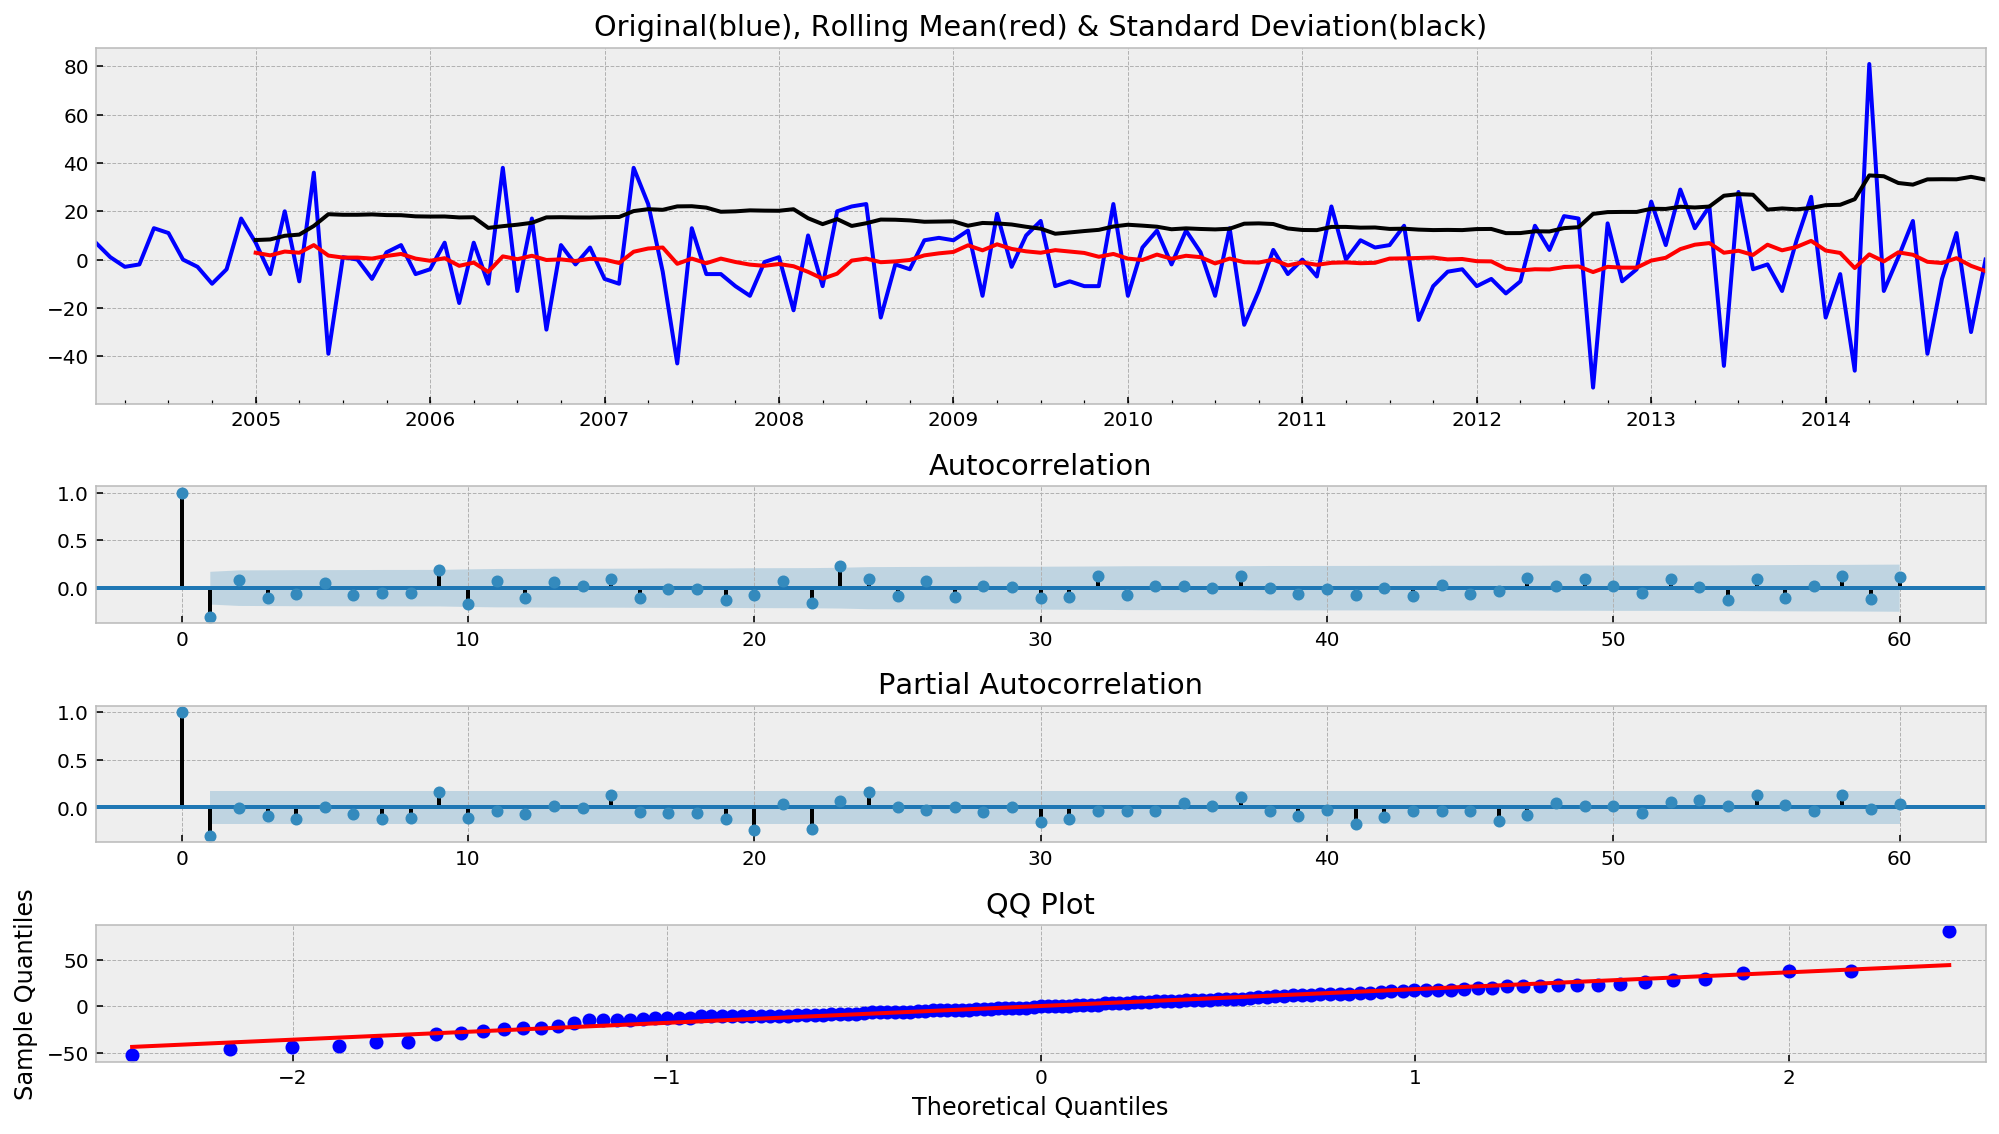

In [143]:
# Удаление сезонной компоненты из ряда с первыми разностями
df['seasonal_first_difference'] = df.first_difference - df.first_difference.shift(12)
test_stationarity(df.seasonal_first_difference.dropna(inplace=False))
tsplot(df.seasonal_first_difference[13:], lags = 60)

Удаление сезонной компоненты из ряда первых разностей дает очень хороший результат. Тест ДФ с очень низким p-value. 
Корелляционные функции после первого лага затухли и колеблются в пределах дисперсии.
QQ plot линейный с единственным выбросом.

Results of Dickey-Fuller Test:
Test Statistic                  -4.480962
p-value                          0.000213
#Lags Used                      12.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


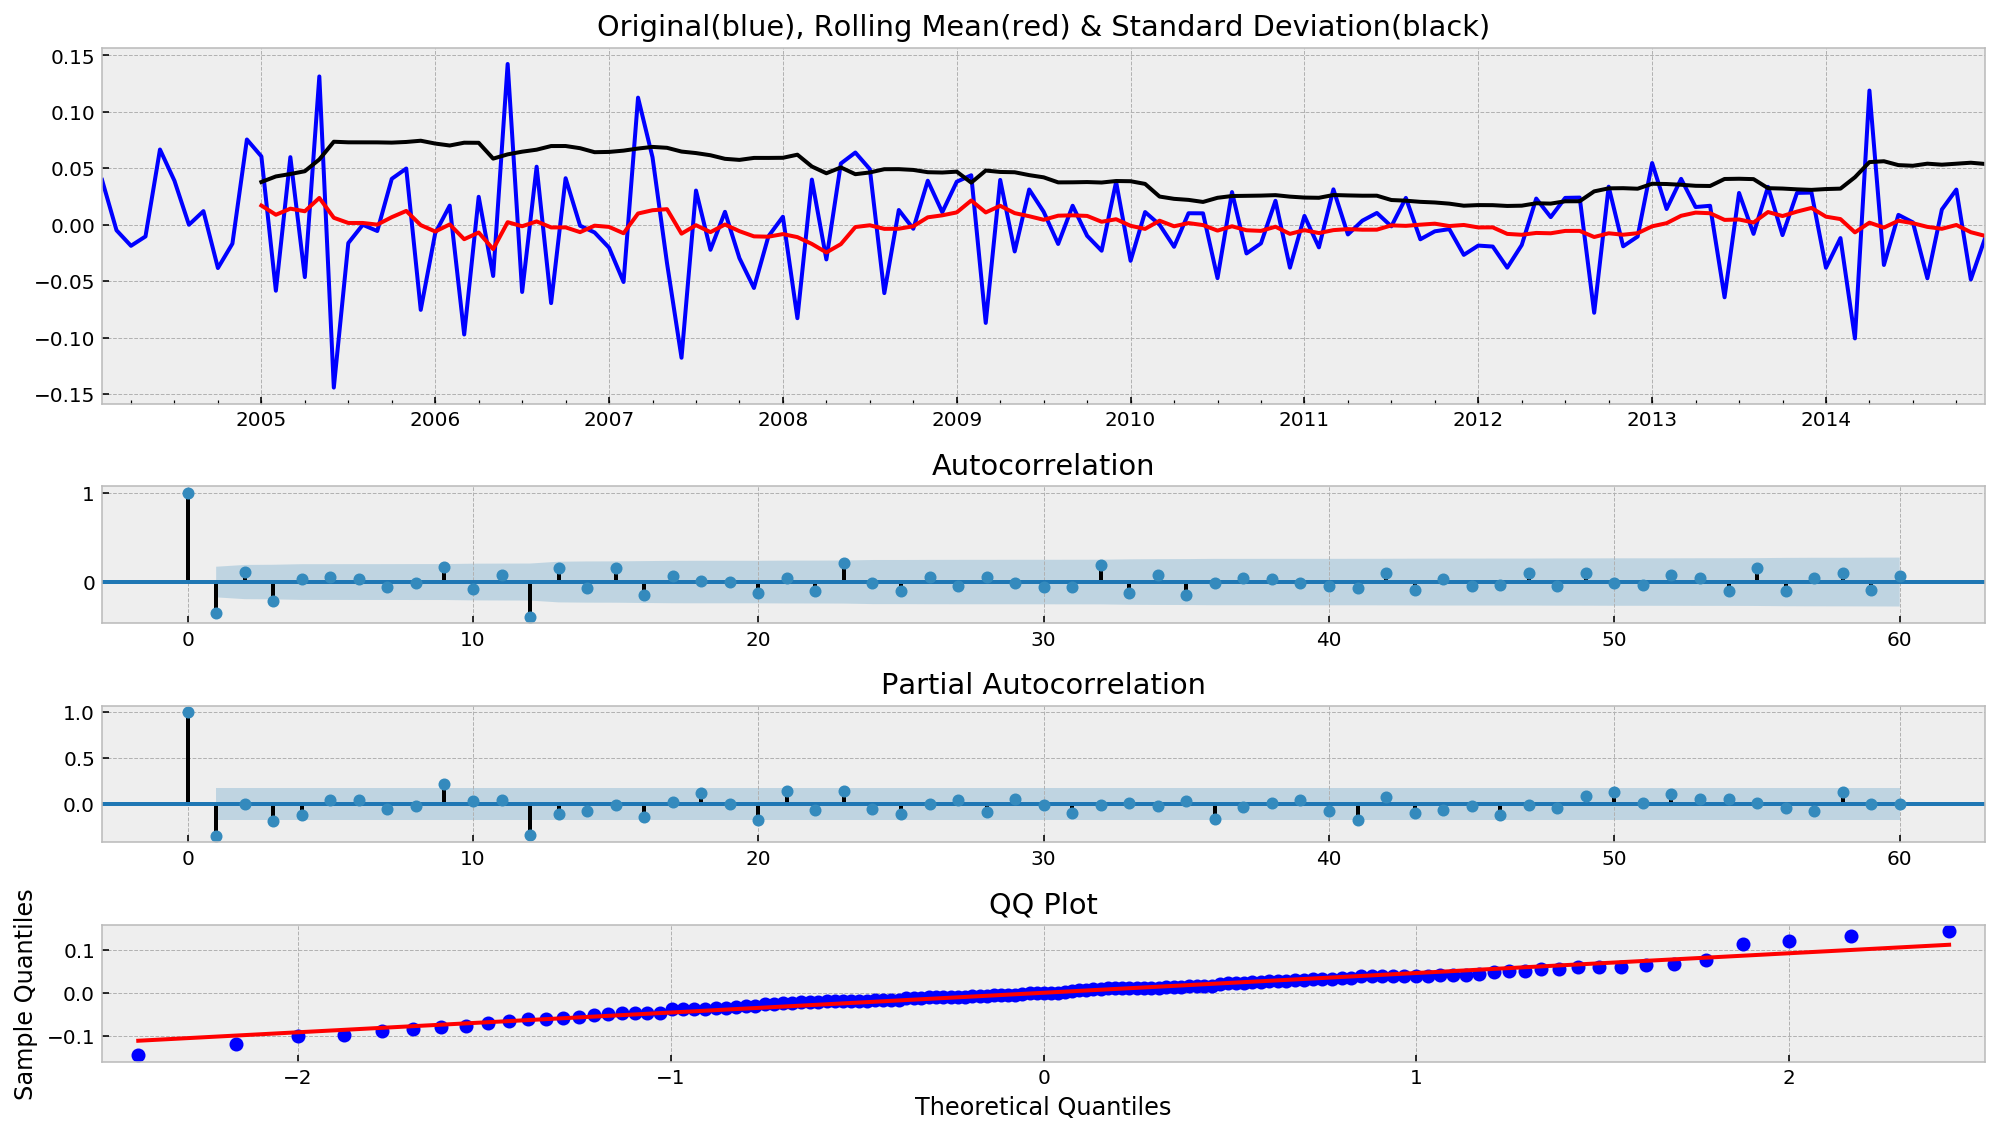

In [144]:
# Удаление сезонной компоненты из логарифмированного ряда первых разностей
df['log_seasonal_first_difference'] = df.log_first_difference - df.log_first_difference.shift(12)
test_stationarity(df.log_seasonal_first_difference.dropna(inplace=False))
tsplot(df.log_seasonal_first_difference[13:], lags = 60)

Удаление сезонной компоненты из логарифмированного ряда первых разностей привело к стационарному ряду, но 
дало не самый лучший результат по оценкам.

В результате экспериментов оказалось, что наилучший способ привести данный ряд к стационарному - удаление сезонной компоненты (12 месяцев) из ряда первых разностей

п. 5 Подберите модель, хорошо описывающую обучающую выборку, каждым способом:

* перебором коэффициентов и сортировкой по AIC;
* перебором коэффициентов и сортировкой по MAP E (mean absolute percentage error);
* с помощью подхода Бокса–Дженкинса к идентификации временных рядов (описан на слайде 22);


а) по AIC

In [166]:
best_mdl = arima_best_order(df.seasonal_first_difference[13:])

aic: 1116.48619 | order: (3, 0, 3)


In [167]:
best_mdl.params

ar.L1.seasonal_first_difference   -0.190539
ar.L2.seasonal_first_difference   -0.120187
ar.L3.seasonal_first_difference    0.711460
ma.L1.seasonal_first_difference   -0.094668
ma.L2.seasonal_first_difference    0.094211
ma.L3.seasonal_first_difference   -0.999493
dtype: float64

In [168]:
best_mdl.forecast(steps= 5, alpha = 1)

(array([  3.4678426 , -11.07484653,  11.83371763,   1.54350844,
         -9.59567646]),
 array([15.80173015, 16.43184749, 16.43796002, 16.94039239, 17.12095632]),
 array([[  3.4678426 ,   3.4678426 ],
        [-11.07484653, -11.07484653],
        [ 11.83371763,  11.83371763],
        [  1.54350844,   1.54350844],
        [ -9.59567646,  -9.59567646]]))

In [169]:
# нарисуем остатки ARIMA
_ = tsplot(, lags=30)

SyntaxError: invalid syntax (<ipython-input-169-8f59630d333c>, line 2)

б) по MAP E